<a href="https://colab.research.google.com/github/federicocampo/CNN_prova/blob/Prime_modifiche/Copy_of_Lecture11_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the dataset from Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Reading the images

In [82]:
from matplotlib import pyplot as plt
from skimage.io import imread
import os
import glob
import numpy as np

import logging
import time

logging.basicConfig(level=logging.INFO)

Fare una read img migliore (?)

In [83]:
def read_imgs(dataset_path, classes):
  tmp = []
  labels = []
  for cls in classes:
    fnames = glob.glob(os.path.join(dataset_path, str(cls), '*.pgm'))
    tmp += [ imread(fname) for fname in fnames ]
    labels += len(fnames)*[cls]
  return np.array(tmp, dtype='float32')[..., np.newaxis]/255, np.array(labels)

In [84]:
PATH = 'gdrive/MyDrive/IMAGES/Mammography_micro'
#PATH = 'gdrive/MyDrive/Immagini'

In [85]:
initial_time = time.time()
train_dataset_path = os.path.join(PATH, 'Train')
x_train, y_train = read_imgs(train_dataset_path, [0, 1])

test_dataset_path =os.path.join(PATH, 'Test')
x_test, y_test = read_imgs(test_dataset_path, [0, 1])

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

elapsed_time=time.time() - initial_time
logging.info('Done in %.2f seconds',elapsed_time )


INFO:root:Done in 1.16 seconds


(396, 60, 60, 1) (396,)
(401, 60, 60, 1) (401,)


# Defining a CNN model

In [14]:
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten, InputLayer, Activation, Dropout
from keras.models import Sequential

In [ ]:
def make_model(shape=(60, 60, 1)):
  model = Sequential([
      
      Conv2D(5, (3,3), padding='same', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),
      MaxPool2D((2,2)),
      
      Conv2D(8, (3,3), padding='same'),
      BatchNormalization(),
      Activation('relu'),
      MaxPool2D((2,2)),
        
      #Conv2D(4, (3,3), padding='same'),
      #BatchNormalization(),
      #Activation('relu'),
      #MaxPool2D(2, 2),


      Flatten(), 
      
      #Dense(32, activation = 'relu'),
      Dense(1, activation='sigmoid')
      
  ])
  
  return model



model = make_model()

In [34]:
def make_model(shape=(60, 60, 1), f1=5, f2=5, f3=5):
  model = Sequential([
      
      Conv2D(f1, (3,3), padding='same', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),
      MaxPool2D((2,2)),
      
      Conv2D(f2, (3,3), padding='same'),
      BatchNormalization(),
      Activation('relu'),
      MaxPool2D((2,2)),

      Conv2D(f3, (3,3), padding='same'),
      BatchNormalization(),
      Activation('relu'),
    

      Flatten(), 
      
      #Dense(32, activation = 'relu'),
      Dense(1, activation='sigmoid')
      
  ])
  
  return model

In [ ]:
#model.summary()

In [45]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import SGD


early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.5,
    patience = 5,
    min_lr=0.00001

)

checkpoint = ModelCheckpoint(
    "model-{epoch:02d}-{val_accuracy:.2f}.hdf5", 
    monitor='val_accuracy', 
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto', save_freq='epoch')


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


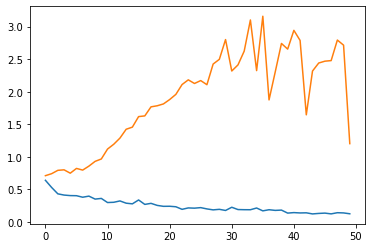

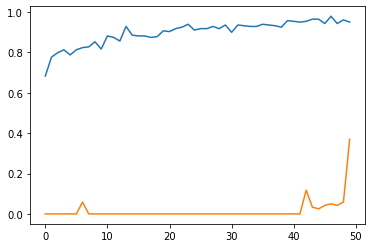

In [47]:
model = make_model(f1=10, f2=10, f3=10)
#model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=SGD(lr = 0.001, momentum = 0.9), metrics = 'accuracy', loss='binary_crossentropy')


history = model.fit(x_train, y_train, 
                    validation_split=0.3, 
                    epochs=50, 
                    batch_size=30, 
                    shuffle=True, 
                    callbacks = [checkpoint],
                    verbose=0)



print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [48]:
model.save(os.path.join(PATH, 'model.hdf5'))
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 60, 60, 10)        100       
_________________________________________________________________
batch_normalization_56 (Batc (None, 60, 60, 10)        40        
_________________________________________________________________
activation_56 (Activation)   (None, 60, 60, 10)        0         
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 30, 30, 10)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 30, 30, 10)        910       
_________________________________________________________________
batch_normalization_57 (Batc (None, 30, 30, 10)        40        
_________________________________________________________________
activation_57 (Activation)   (None, 30, 30, 10)      

# Data augmentation
 Before we can run data aumentation with ImageDataGenerator we need to convert the PGM format to PNG

In [ ]:
basename = os.path.basename(PATH)
print(basename)

Mammography_micro


In [51]:
import PIL
import os

In [52]:
def convert_to_png(fname, dest_folder):
  if not os.path.exists(dest_folder):
    os.makedirs(dest_folder)
  dest_fname = os.path.basename(fname).replace('.pgm', '.png')
  dest_fname = os.path.join(dest_folder, dest_fname)
  PIL.Image.open(fname).convert('L').save(dest_fname)


Provare a fare una funzione migliore per convertire tutti i pgm in png

In [ ]:
start_time = time.time()
for data_path in [os.path.join(PATH, "Train"), os.path.join(PATH, "Test")]:
  for path, folders, fnames in os.walk(data_path):
    for fname in fnames:
      abs_path = os.path.join(path, fname)
      dest_folder = path.replace('Train', 'Train_png').replace('Test', 'Test_png')
      convert_to_png(abs_path, dest_folder)
print(time.time()-start_time)

# Data aumentation

In [55]:
import matplotlib.pyplot as plt

In [56]:
from keras.preprocessing.image import ImageDataGenerator

Found 239 images belonging to 2 classes.
Found 157 images belonging to 2 classes.
1.0


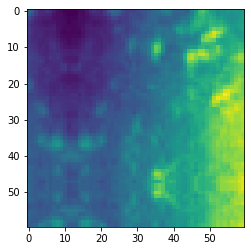

In [193]:
train_dataset_path = os.path.join(PATH, "Train_png")
img_width, img_height = (60, 60)

train_datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split=0.4)
        



train_gen = train_datagen.flow_from_directory(
    train_dataset_path,
    target_size=(img_width, img_height),
    color_mode='grayscale', 
    class_mode='binary',
    subset='training')

val_gen = train_datagen.flow_from_directory(
    train_dataset_path,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    class_mode='binary',
    subset='validation')

img = train_gen.next()[0][0].squeeze()
plt.imshow(img) #facendo cosi ne mostra una diversa ogni volta 
print(train_gen.next()[1][0])

In [162]:
#print(train_gen)
#plt.imshow(train_gen)

In [67]:
train_gen.next()[0].shape

(32, 60, 60, 1)

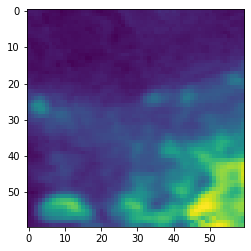

In [60]:
plt.imshow(train_gen.next()[0][10].squeeze())

# Testing model on new images

In [68]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    "model_augmented.{epoch:02d}-{val_accuracy:.2f}.h5", 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto', save_freq='epoch')

In [69]:
model = make_model()
model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
batch_size=32
history = model.fit(
        train_gen,
        steps_per_epoch=278 // batch_size,
        epochs=50,
        validation_data=val_gen,
        validation_steps= 118 // batch_size,
        verbose=0,
        callbacks=[checkpoint])

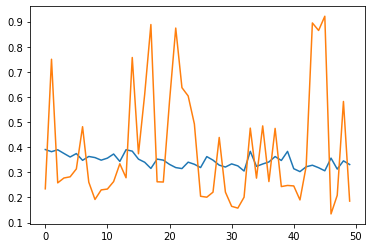

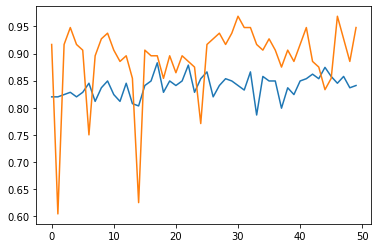

In [75]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

Saving the model

In [76]:
model.save(os.path.join(PATH, 'model_augmented.hdf5'))

# Evaluate the performances of the two models

In [78]:
from keras.models import load_model
aug_model = load_model(os.path.join(PATH, 'model_augmented.hdf5'))
noaug_model = load_model(os.path.join(PATH, 'model.hdf5'))

In [80]:
x_test, y_test = read_imgs(os.path.join(PATH, "Test"), [0,1])

In [81]:
noaug_model.evaluate(x_test, y_test)

aug_model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 2ms/step - loss: 0.3494 - accuracy: 0.8329


[0.34938904643058777, 0.8329176902770996]

# Visualizing

In [ ]:
model= load_model(os.path.join(PATH, 'model_augmented.hdf5'))

In [ ]:
from keras import models
layer_outputs = [layer.output for layer in model.layers]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
micro_calc = val_gen.next()[0][2][np.newaxis,...]

In [ ]:
plt.imshow(micro_calc.squeeze())

In [ ]:
activations = activation_model.predict(micro_calc)

In [ ]:
len(activations) == len(model.layers)

In [ ]:
activations[0].shape

In [ ]:
fig = plt.figure(figsize=(10,10))
for k in range(8):
  plt.subplot(2,4, k+1)
  plt.imshow(activations[0][..., k].squeeze())
  plt.axis(False)
fig.subplots_adjust(hspace=-0.5, wspace=0.2)
fig.tight_layout(pad=1)

In [ ]:
fig = plt.figure(figsize=(15,15))

for k in range(16):
  plt.subplot(2,8, k+1)
  plt.imshow(activations[5][..., k].squeeze())
  plt.axis(False)
fig.subplots_adjust(hspace=-0.9, wspace=0.2)
fig.tight_layout(pad=1)

In [ ]:
fig = plt.figure(figsize=(15,15))
for k in range(16):
  plt.subplot(4,8, k+1)
  plt.imshow(activations[8][..., k].squeeze())
  plt.axis(False)
fig.subplots_adjust(hspace=-0.9, wspace=0.2)
fig.tight_layout(pad=1)

## Visualizing filters

In [ ]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[0].get_weights()
filters = (filters - filters.min())/(filters.max() - filters.min())
filters = filters.squeeze()

In [ ]:
for k in range(8):
  plt.subplot(2, 4, k+1)
  plt.imshow(filters[:,:,k], cmap='gray')
  plt.axis(False)

In [ ]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[4].get_weights()
filters = (filters - filters.min())/(filters.max() - filters.min())
filters = filters.squeeze()
for k in range(16):
  plt.subplot(2, 8, k+1)
  plt.imshow(filters[:,:,1 ,k], cmap='gray')
  plt.axis(False)

In [ ]:
filters.shape

(3, 3, 8, 16)